# Task 2.2
Development of a classification model for discriminating between 4 classes: malignant masses, benign masses, malignant calcification and benign calcification. Design and development of an ad-hoc CNN architecture (training from scratch).

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from google.colab import drive
import numpy as np


TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
drive.mount('/content/drive')
os.listdir()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['.config', 'drive', 'sample_data']

In [0]:
base_dir = 'drive/My Drive/Computational Intelligence - MY PROJECT/My_Project_CompInt' 
os.listdir(base_dir)

['OldNotebooks',
 'Task 1',
 'Models',
 'Task4_RelevantPapers',
 'Task 3.1_ INCEPTIONV3.ipynb',
 'Tensors',
 'Task3.2_INCEPTION.ipynb',
 'Task2.1_With Data Aug.ipynb',
 'Task3.2_VGG16.ipynb',
 'Task4.ipynb',
 'Task3.1_VGG16.ipynb',
 'Task5.ipynb',
 'Task2.2.ipynb']

# Data manipulation

In [0]:

def load_training():
  train_images = np.load(os.path.join(base_dir,'Tensors/train_tensor.npy'))
  train_labels = np.load(os.path.join(base_dir,'Tensors/train_labels.npy'))
  test_images = np.load(os.path.join(base_dir,'Tensors/public_test_tensor.npy'))
  test_lables = np.load(os.path.join(base_dir,'Tensors/public_test_labels.npy'))
  return train_images,train_labels, test_images, test_lables
 
train_images, train_labels, test_images, test_lable = load_training()




## Reshape

In [0]:
#reshape per poter fittare la CNN
train_images = train_images.reshape((5352, 150, 150,1))
train_images = train_images.astype('float32') / 65535           
test_images = test_images.reshape((672, 150, 150,1))
test_images = test_images.astype('float32') / 65535

In [0]:
print(train_images[0:100])

## Removing the baseline

In [0]:
#Here i manage the input tensors, removing the baseline patch and the relative labels in order to perform classification
SubTrainArray =  np.empty_like(train_images)
SubTrainArray =  np.delete(train_images, np.s_[::2], 0)
print(SubTrainArray[1]) 
SubLabelArray = np.empty_like(train_labels)
SubLabelArray =  np.delete(train_labels, np.s_[::2], 0)



## Editing the label 

In [0]:
#to_categorical requires that the label should be in the range [0,number_Class] 
leng = len(SubLabelArray)
SubLabelArray_4 = np.empty_like(SubLabelArray)
for i in range(leng):
    if SubLabelArray[i] == 1:
      SubLabelArray_4[i] = 0
    if SubLabelArray[i] == 2:
      SubLabelArray_4[i] = 1
    if SubLabelArray[i] == 3:
      SubLabelArray_4[i] = 2
    if SubLabelArray[i] == 4:
      SubLabelArray_4[i] = 3

print(SubLabelArray_4[0:1000])
print(SubLabelArray_4[2000:])



## To categorical

In [0]:

from keras.utils import to_categorical
SubLabelArray_Categorical = to_categorical(SubLabelArray_4,4)

Using TensorFlow backend.


In [0]:
print(SubLabelArray_Categorical[0:1000])
print(SubLabelArray_Categorical[2000:])

## Shuffle

In [0]:
#eseguo uno shuffle dei dati CON SOFTMAX
 from sklearn.utils import shuffle

SubTrainArray_Shuffled, SubLabelArray_Shuffled = shuffle( SubTrainArray, SubLabelArray_Categorical, random_state=42)



In [0]:
#Printing in order to check if the shuffled has been performed well
print(SubTrainArray_Shuffled[0:1000])
print(SubLabelArray_Shuffled[2000:3000])


## Modifiyng the test set

In [0]:
#Here i manage the TEST data set, removing baseline
SubTestArray =  np.empty_like(test_images)
SubTestArray =  np.delete(test_images, np.s_[::2], 0)

SubTestLabelArray = np.empty_like(test_lable)
SubTestLabelArray =  np.delete(test_lable, np.s_[::2], 0)
print(SubTestLabelArray[0:1000])
print(SubTestLabelArray[2000:3000])

[2 2 2 2 1 1 2 2 1 2 2 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 1 1 1 1 2 2 1 1 2 2 2 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 2 1
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2
 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 1 2 1
 1 1 1 2 2 1 1 1 1 1 2 2 2 1 1 2 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 3 4 4 3 3 3 3
 3 3 4 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 3 3 4 4 3 3 4 4 4 4 4 4
 4 3 3 3 3 4 4 4 3 3 3 3 3 3 4 3 3 3 3 3 3 4 4 4 4 3 3 3 3 4 3 3 4 4 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 3 3 3 3 3 3 3
 3 3 3]
[]


In [0]:
leng = len(SubTestLabelArray)
SubTestLabelArray_Edited = np.empty_like(SubTestLabelArray)
for i in range(leng):
    if SubTestLabelArray[i] == 1:
      SubTestLabelArray_Edited[i] = 0
    if SubTestLabelArray[i] == 2:
      SubTestLabelArray_Edited[i] = 1
    if SubTestLabelArray[i] == 3:
      SubTestLabelArray_Edited[i] = 2
    if SubTestLabelArray[i] == 4:
      SubTestLabelArray_Edited[i] = 3

print(SubTestLabelArray_Edited[0:1000])
print(SubTestLabelArray_Edited[1000:])

[1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0
 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 2 2 2 3 3 2 2 2 2
 2 2 3 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 2 2 3 3 2 2 3 3 3 3 3 3
 3 2 2 2 2 3 3 3 2 2 2 2 2 2 3 2 2 2 2 2 2 3 3 3 3 2 2 2 2 3 2 2 3 3 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 2 2 2 2 2 2 2
 2 2 2]
[]


In [0]:

from keras.utils import to_categorical
SubTestLabelArray_Categorical = to_categorical(SubTestLabelArray_Edited,4)

In [0]:
print(len(SubTestLabelArray_Categorical))
print(SubTestLabelArray_Categorical[0:300])

336
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


# Building The Network: Base version

## Define the model

In [0]:
keras.layers.Conv2D?
keras.layers.MaxPooling2D?
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 1),padding='same',strides=1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same',strides=1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(192, (3, 3), activation='relu',padding='same',strides=1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))



In [0]:
model.summary()#a summary of the architecture

In [0]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

## 10-Cross validation

processing fold # 0
Train on 2409 samples, validate on 267 samples
Epoch 1/40
2409/2409 [==============================] - 2s 950us/sample - loss: 1.3660 - categorical_accuracy: 0.3520 - val_loss: 1.3633 - val_categorical_accuracy: 0.3596
Epoch 2/40
2409/2409 [==============================] - 2s 652us/sample - loss: 1.3513 - categorical_accuracy: 0.3537 - val_loss: 1.3422 - val_categorical_accuracy: 0.3596
Epoch 3/40
2409/2409 [==============================] - 2s 654us/sample - loss: 1.3078 - categorical_accuracy: 0.4006 - val_loss: 1.2843 - val_categorical_accuracy: 0.4270
Epoch 4/40
2409/2409 [==============================] - 2s 647us/sample - loss: 1.2534 - categorical_accuracy: 0.4433 - val_loss: 1.2335 - val_categorical_accuracy: 0.4457
Epoch 5/40
2409/2409 [==============================] - 2s 649us/sample - loss: 1.2332 - categorical_accuracy: 0.4371 - val_loss: 1.1519 - val_categorical_accuracy: 0.4981
Epoch 6/40
2409/2409 [==============================] - 2s 649us/sample -

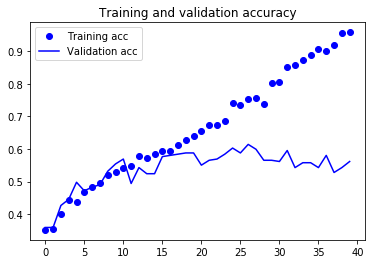

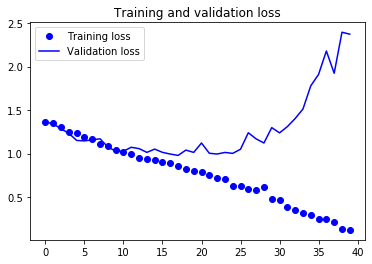

processing fold # 1
Train on 2409 samples, validate on 267 samples
Epoch 1/40
2336/2409 [============================>.] - ETA: 0s - loss: 1.3649 - categorical_accuracy: 0.3472

KeyboardInterrupt: ignored

In [0]:
#cross-validation, SUL TRAINING ESTRATTO e shuffled
import numpy as np
keras.layers.Conv2D?
keras.layers.MaxPooling2D?
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
def get_model():


  Cross_model = models.Sequential()

  Cross_model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 1),padding='same',strides=1))
  Cross_model.add(layers.MaxPooling2D((2, 2)))
  Cross_model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same',strides=1))
  Cross_model.add(layers.MaxPooling2D((2, 2)))
  Cross_model.add(layers.Conv2D(192, (3, 3), activation='relu',padding='same',strides=1))
  Cross_model.add(layers.MaxPooling2D((2, 2)))
  Cross_model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1))
  Cross_model.add(layers.MaxPooling2D((2, 2)))
  Cross_model.add(layers.Flatten())
  Cross_model.add(layers.Dense(256, activation='relu'))
  Cross_model.add(layers.Dense(64, activation='relu'))
  Cross_model.add(layers.Dense(32, activation='relu'))
  Cross_model.add(layers.Dense(4, activation='softmax'))

  return Cross_model

def plot():
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  return


############################# CROSS VALIDATION ######################

k = 10
num_val_samples = len(SubTrainArray_Shuffled) // k
num_epochs = 40
History_Arr =[]
Cross_model = get_model()
Cross_model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

for i in range(k):
  print('processing fold #', i)
  val_data = SubTrainArray_Shuffled[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = SubLabelArray_Shuffled[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([SubTrainArray_Shuffled[:i * num_val_samples],SubTrainArray_Shuffled[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([SubLabelArray_Shuffled[:i * num_val_samples],SubLabelArray_Shuffled[(i + 1) * num_val_samples:]],axis=0)
  history = Cross_model.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=32)
  History_Arr.append(history)
  Cross_model = get_model()
  Cross_model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  plot()

## FITTING COMPLETO
Dopo la cross validation, fitto su tutto il DATASET

In [0]:
 history = model.fit(SubTrainArray_Shuffled, SubLabelArray_Shuffled, epochs=5,callbacks=[callback], batch_size=32)


Train on 2676 samples
Epoch 1/5
2676/2676 [==============================] - 2s 801us/sample - loss: 0.2126 - categorical_accuracy: 0.9137
Epoch 2/5
2676/2676 [==============================] - 2s 809us/sample - loss: 0.2524 - categorical_accuracy: 0.9062
Epoch 3/5
2676/2676 [==============================] - 2s 799us/sample - loss: 0.2748 - categorical_accuracy: 0.8924
Epoch 4/5
2676/2676 [==============================] - 2s 801us/sample - loss: 0.1819 - categorical_accuracy: 0.9327
Epoch 5/5
2676/2676 [==============================] - 2s 804us/sample - loss: 0.1767 - categorical_accuracy: 0.9275


## Plotting

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evalutate the model

In [0]:
#evaluate the model


test_loss, test_acc = model.evaluate(SubTestArray, SubTestLabelArray_Categorical,batch_size=32, verbose= 1)
print(test_loss)
print(test_acc)

336/336 [==============================] - 0s 380us/sample - loss: 3.2164 - categorical_accuracy: 0.4583
3.2164277689797536
0.45833334


## Load OR Save the model

In [0]:
#Restore the saved model
model = tf.keras.models.load_model(os.path.join(base_dir,'Models/Model_Task_2.2_BaseVersion_0.55.h5'))

# Show the model architecture
model.summary()

In [0]:
#Save the model!
model.save(os.path.join(base_dir,'Models/Model_Task_2.2_BaseVersion_0.55.h5'))

# Building The Network: Adding DROPOUT and weight regularization

## Define the model

In [0]:
keras.layers.Conv2D?
keras.layers.MaxPooling2D?
from tensorflow.keras import layers
from tensorflow.keras import models

activation_Leaky = keras.layers.LeakyReLU(0.2)


model_DropOut = models.Sequential()


model_DropOut.add(layers.Conv2D(32, (3, 3), activation=activation_Leaky,input_shape=(150, 150, 1),padding='same',strides=1))
model_DropOut.add(layers.MaxPooling2D((2, 2)))
model_DropOut.add(layers.Conv2D(64, (3, 3), activation=activation_Leaky,padding='same',strides=1,kernel_regularizer=keras.regularizers.l2(0.001)))
model_DropOut.add(layers.MaxPooling2D((2, 2)))
model_DropOut.add(layers.Conv2D(192, (2, 2), activation=activation_Leaky,padding='same',strides=1,kernel_regularizer=keras.regularizers.l2(0.001)))
model_DropOut.add(layers.MaxPooling2D((2, 2)))
model_DropOut.add(layers.Conv2D(256, (2, 2), activation=activation_Leaky,padding='same',strides=1,kernel_regularizer=keras.regularizers.l2(0.001)))
model_DropOut.add(layers.MaxPooling2D((2, 2)))
model_DropOut.add(layers.Flatten())
model_DropOut.add(layers.Dense(256, activation=activation_Leaky))
model_DropOut.add(layers.Dropout(0.4))
model_DropOut.add(layers.Dense(128, activation=activation_Leaky))
model_DropOut.add(layers.Dropout(0.4))
model_DropOut.add(layers.Dense(32, activation=activation_Leaky))
model_DropOut.add(layers.Dense(4, activation='softmax'))

#model_DropOut.add(layers.Conv2D(32, (3, 3), activation=layers.LeakyReLU(alpha=0.2),input_shape=(150, 150, 1),padding='same',strides=1,))




In [0]:
model_DropOut.summary()#a summary of the architecture

In [0]:
model_DropOut.compile(optimizer='RMSprop',loss='categorical_crossentropy', metrics=['categorical_accuracy'])




In [0]:
#early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=5)

## CrossValidation

processing fold # 0
Train on 2409 samples, validate on 267 samples
Epoch 1/40
2409/2409 [==============================] - 5s 2ms/sample - loss: 1.6742 - categorical_accuracy: 0.3371 - val_loss: 1.5783 - val_categorical_accuracy: 0.3596
Epoch 2/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 1.5491 - categorical_accuracy: 0.3479 - val_loss: 1.5108 - val_categorical_accuracy: 0.3596
Epoch 3/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 1.4890 - categorical_accuracy: 0.3562 - val_loss: 1.4487 - val_categorical_accuracy: 0.3596
Epoch 4/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 1.4090 - categorical_accuracy: 0.3981 - val_loss: 1.3476 - val_categorical_accuracy: 0.4532
Epoch 5/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 1.3362 - categorical_accuracy: 0.4379 - val_loss: 1.2712 - val_categorical_accuracy: 0.4981
Epoch 6/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 1.292

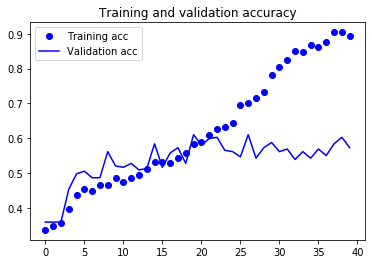

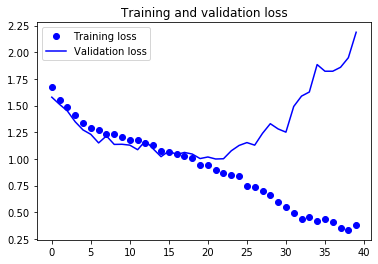

processing fold # 1
Train on 2409 samples, validate on 267 samples
Epoch 1/40
2409/2409 [==============================] - 5s 2ms/sample - loss: 1.6968 - categorical_accuracy: 0.3254 - val_loss: 1.5989 - val_categorical_accuracy: 0.3933
Epoch 2/40
1376/2409 [================>.............] - ETA: 1s - loss: 1.6013 - categorical_accuracy: 0.3358

KeyboardInterrupt: ignored

In [0]:
#cross-validation, SUL TRAINING ESTRATTO e shuffled
import numpy as np
keras.layers.Conv2D?
keras.layers.MaxPooling2D?
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt

activation_Leaky = keras.layers.LeakyReLU(alpha=0.2)
def get_model():
  Cross_model = models.Sequential()
    
  Cross_model.add(layers.Conv2D(32, (3, 3), activation=activation_Leaky,input_shape=(150, 150, 1),padding='same',strides=1))
  Cross_model.add(layers.MaxPooling2D((2, 2)))
  Cross_model.add(layers.Conv2D(64, (3, 3), activation=activation_Leaky,padding='same',strides=1,kernel_regularizer=keras.regularizers.l2(0.001)))
  Cross_model.add(layers.MaxPooling2D((2, 2)))
  Cross_model.add(layers.Conv2D(192, (2, 2), activation=activation_Leaky,padding='same',strides=1,kernel_regularizer=keras.regularizers.l2(0.001)))
  Cross_model.add(layers.Conv2D(256, (2, 2), activation=activation_Leaky,padding='same',strides=1,kernel_regularizer=keras.regularizers.l2(0.001)))
  Cross_model.add(layers.MaxPooling2D((2, 2)))
  Cross_model.add(layers.Flatten())
  Cross_model.add(layers.Dense(256, activation=activation_Leaky))
  Cross_model.add(layers.Dropout(0.4))
  Cross_model.add(layers.Dense(128, activation=activation_Leaky))
  Cross_model.add(layers.Dropout(0.4))
  Cross_model.add(layers.Dense(32, activation=activation_Leaky))
  Cross_model.add(layers.Dense(4, activation='softmax'))
  return Cross_model

def plot():
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  return

k = 10
num_val_samples = len(SubTrainArray_Shuffled) // k
num_epochs = 40

Cross_model = get_model()
Cross_model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

for i in range(k):
  print('processing fold #', i)
  val_data = SubTrainArray_Shuffled[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = SubLabelArray_Shuffled[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([SubTrainArray_Shuffled[:i * num_val_samples],SubTrainArray_Shuffled[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([SubLabelArray_Shuffled[:i * num_val_samples],SubLabelArray_Shuffled[(i + 1) * num_val_samples:]],axis=0)
  history = Cross_model.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets), epochs=num_epochs,callbacks=[callback], batch_size=32)
  Cross_model = get_model()
  Cross_model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  plot()



## FITTING COMPLETO
Dopo la cross validation, fitto su tutto il DATASET

In [0]:
 history = model_DropOut.fit(SubTrainArray_Shuffled, SubLabelArray_Shuffled, epochs=40
                             ,callbacks=[callback], batch_size=32)


Train on 2676 samples
Epoch 1/40
2676/2676 [==============================] - 3s 1ms/sample - loss: 1.4541 - categorical_accuracy: 0.3408
Epoch 2/40
2676/2676 [==============================] - 3s 1ms/sample - loss: 1.4160 - categorical_accuracy: 0.3554
Epoch 3/40
2676/2676 [==============================] - 3s 1ms/sample - loss: 1.3792 - categorical_accuracy: 0.3625
Epoch 4/40
2676/2676 [==============================] - 3s 1ms/sample - loss: 1.3028 - categorical_accuracy: 0.4215
Epoch 5/40
2676/2676 [==============================] - 3s 1ms/sample - loss: 1.2801 - categorical_accuracy: 0.4316
Epoch 6/40
2676/2676 [==============================] - 3s 1ms/sample - loss: 1.2289 - categorical_accuracy: 0.4559
Epoch 7/40
2676/2676 [==============================] - 3s 1ms/sample - loss: 1.2331 - categorical_accuracy: 0.4690
Epoch 8/40
2676/2676 [==============================] - 3s 1ms/sample - loss: 1.2295 - categorical_accuracy: 0.4757
Epoch 9/40
2676/2676 [============================

## Evalutate the model

In [0]:
#evaluate the model


test_loss, test_acc = model_DropOut.evaluate(SubTestArray, SubTestLabelArray_Categorical, verbose= 1)
print(test_loss)
print(test_acc)

336/336 [==============================] - 1s 3ms/sample - loss: 3.7491 - categorical_accuracy: 0.5327
3.749097767330351
0.5327381


## Plotting

In [0]:
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Load OR Save the model

In [0]:
#Save the model!
model_DropOut.save(os.path.join(base_dir,'Models/Model_Task_2.2_WithDROPOUT_Definitivo_0.56.h5'))

In [0]:
#Restore the saved model
model_DropOut = tf.keras.models.load_model(os.path.join(base_dir,'Models/Model_Task_2.1_WithDROPOUT_Definitivo_0.8.h5'))

# Show the model architecture
model_DropOut.summary()

# Building The Network: Adding Data Augmentation

## Define the model

In [0]:
keras.layers.Conv2D?
keras.layers.MaxPooling2D?
from tensorflow.keras import layers
from tensorflow.keras import models

model_DropOut_Augmented = models.Sequential()

activation_Leaky = keras.layers.LeakyReLU(alpha=0.2)
  
model_DropOut_Augmented.add(layers.Conv2D(32, (3, 3), activation=activation_Leaky,input_shape=(150, 150, 1),padding='same',strides=1, ))
model_DropOut_Augmented.add(layers.MaxPooling2D((2, 2)))
model_DropOut_Augmented.add(layers.Conv2D(64, (3, 3), activation=activation_Leaky,padding='same',strides=1,kernel_regularizer=keras.regularizers.l2(0.001)))
model_DropOut_Augmented.add(layers.MaxPooling2D((2, 2)))
model_DropOut_Augmented.add(layers.Conv2D(128, (3, 3), activation=activation_Leaky,padding='same',strides=1,kernel_regularizer=keras.regularizers.l2(0.001)))
model_DropOut_Augmented.add(layers.MaxPooling2D((2, 2)))
model_DropOut_Augmented.add(layers.Conv2D(192, (3, 3), activation=activation_Leaky,padding='same',strides=1,kernel_regularizer=keras.regularizers.l2(0.001)))
model_DropOut_Augmented.add(layers.AveragePooling2D((2, 2)))
model_DropOut_Augmented.add(layers.Flatten())
model_DropOut_Augmented.add(layers.Dense(192, activation=activation_Leaky))
model_DropOut_Augmented.add(layers.Dropout(0.4))
model_DropOut_Augmented.add(layers.Dense(128, activation=activation_Leaky))
model_DropOut_Augmented.add(layers.Dropout(0.4))
model_DropOut_Augmented.add(layers.Dense(64, activation=activation_Leaky))
model_DropOut_Augmented.add(layers.Dense(4, activation='softmax'))

In [0]:
model_DropOut_Augmented.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=5)


In [0]:
from tensorflow.keras.utils import to_categorical
def load_training():
  train_images = np.load(os.path.join(base_dir,'Tensors/train_tensor.npy'))
  train_labels = np.load(os.path.join(base_dir,'Tensors/train_labels.npy'))
  test_images = np.load(os.path.join(base_dir,'Tensors/public_test_tensor.npy'))
  test_lables = np.load(os.path.join(base_dir,'Tensors/public_test_labels.npy'))
  return train_images,train_labels, test_images, test_lables
 
train_images_Augmented, train_labels_Augmented, test_images_Augmented, test_lable_Augmented = load_training()

train_images_Augmented = train_images_Augmented.reshape((5352, 150, 150,1))
test_images_Augmented = test_images_Augmented.reshape((672, 150, 150,1))



## Deleting the baseline

In [0]:
#Here i manage the input tensors, removing the baseline patch and the relative labels in order to perform binary classification
SubTrainArray_AG =  np.empty_like(train_images_Augmented)
SubTrainArray_AG  =  np.delete(train_images_Augmented, np.s_[::2], 0)
print(SubTrainArray_AG[1])
SubLabelArray_AG  = np.empty_like(train_labels_Augmented)
SubLabelArray_AG  =  np.delete(train_labels_Augmented, np.s_[::2], 0)
print(SubLabelArray_AG[0:100])


## Editing the label 

In [0]:
#Here i manage the input tensor and the label in order to perform binary classification

leng = len(SubLabelArray_AG)
SubLabelArray_Edited_AG = np.empty_like(SubLabelArray_AG)


for i in range(leng):
    if SubLabelArray_AG[i] == 1:
      SubLabelArray_Edited_AG[i] = 0
    if SubLabelArray_AG[i] == 2:
      SubLabelArray_Edited_AG[i] = 1
    if SubLabelArray_AG[i] == 3:
      SubLabelArray_Edited_AG[i] = 2
    if SubLabelArray_AG[i] == 4:
      SubLabelArray_Edited_AG[i] = 3



print(SubLabelArray_Edited_AG[0:1000])
print(SubLabelArray_Edited_AG[2000:])


## Shuffle

In [0]:
#eseguo uno shuffle dei dati 
 from sklearn.utils import shuffle

 SubTrainArray_Shuffled_AG, SubLabelArray_Shuffled_AG = shuffle( SubTrainArray_AG, SubLabelArray_Edited_AG, random_state=42)



In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical



train_data, val_data, train_targets, val_targets = train_test_split(SubTrainArray_Shuffled_AG, SubLabelArray_Shuffled_AG, test_size=0.1, stratify=SubLabelArray_Shuffled_AG)




In [0]:
Train_target_cat = to_categorical(train_targets,4)
Val_target_cat = to_categorical(val_targets,4)

In [0]:
print(train_data.shape)

(2408, 150, 150, 1)


## Modifiyng the test set

In [0]:
#Here i manage the TEST data set, removing baseline
SubTestArray_Augmented =  np.empty_like(test_images_Augmented)
SubTestArray_Augmented =  np.delete(test_images_Augmented, np.s_[::2], 0)

SubTestLabelArray_Augmented = np.empty_like(test_lable_Augmented)
SubTestLabelArray_Augmented =  np.delete(test_lable_Augmented, np.s_[::2], 0)
print(SubTestLabelArray_Augmented[0:1000])
print(SubTestLabelArray_Augmented[2000:3000])

In [0]:
leng = len(SubTestLabelArray_Augmented)
SubTestLabelArray_Augmented_Edited = np.empty_like(SubTestLabelArray_Augmented)
for i in range(leng):
    if SubTestLabelArray_Augmented[i] == 1:
      SubTestLabelArray_Augmented_Edited[i] = 0
    if SubTestLabelArray_Augmented[i] == 2:
      SubTestLabelArray_Augmented_Edited[i] = 1
    if SubTestLabelArray_Augmented[i] == 3:
      SubTestLabelArray_Augmented_Edited[i] = 2
    if SubTestLabelArray_Augmented[i] == 4:
      SubTestLabelArray_Augmented_Edited[i] = 3

print(SubTestLabelArray_Augmented_Edited[0:1000])
print(SubTestLabelArray_Augmented_Edited[1000:])

In [0]:

from keras.utils import to_categorical
SubTestLabelArray_Augmented_Categorical = to_categorical(SubTestLabelArray_Augmented_Edited,4)

In [0]:
print(len(SubTestLabelArray_Augmented_Categorical))
print(SubTestLabelArray_Augmented_Categorical[0:200])

## Data Augmentation

In [0]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./65535,
      rotation_range=360,
      zoom_range=0.1, 
      horizontal_flip=True,
      vertical_flip = True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535)


In [0]:


train_generator = train_datagen.flow(
        # This is the target directory
        train_data,
        Train_target_cat,
        batch_size=32
        )

validation_generator = validation_datagen.flow(
        val_data,
        Val_target_cat,
        batch_size=32)
test_generator = test_datagen.flow(
        SubTestArray_Augmented,
        SubTestLabelArray_Augmented_Categorical,
        batch_size=32)

In [0]:
import matplotlib.pyplot as plt

augmented_images = [train_generator[0][0][0] for i in range(5)]
for data_batch, labels_batch in train_generator:
    plt.imshow(np.squeeze(data_batch[3]), cmap='Greys')
    plt.show()
    plt.imshow(np.squeeze(data_batch[4]), cmap='Greys')
    plt.show()
    plt.imshow(np.squeeze(data_batch[5]), cmap='Greys')
    plt.show()
    plt.imshow(np.squeeze(data_batch[1]), cmap='Greys')
    plt.show()
    plt.imshow(np.squeeze(data_batch[2]), cmap='Greys')
    plt.show()
    break

## FITTING

In [0]:
  history = model_DropOut_Augmented.fit_generator(
        train_generator,
        steps_per_epoch=2408//32,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=268//32)

75/75 [==============================] - 4s 55ms/step - loss: 0.7399 - categorical_accuracy: 0.6940 - val_loss: 0.8305 - val_categorical_accuracy: 0.6758
  ...
    to  
  ['...']
11/11 [==============================] - 0s 10ms/step - loss: 0.9065 - categorical_accuracy: 0.6190
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 8 steps
75/75 [==============================] - 4s 55ms/step - loss: 0.7336 - categorical_accuracy: 0.6987 - val_loss: 0.8310 - val_categorical_accuracy: 0.6641
  ...
    to  
  ['...']
11/11 [==============================] - 0s 10ms/step - loss: 0.8895 - categorical_accuracy: 0.6161
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 8 steps
75/75 [==============================] - 4s 56ms/step - loss: 0.7493 - categorical_accuracy: 0.6928 - val_loss: 0.8311 - val_categorical_accuracy: 0.6875
  ...
    to  
  ['...']
11/11 [==============================] - 0s 9ms/step - loss: 0.9293 - categorical

## Evalutate the model

In [0]:
#evaluate the model


test_loss, test_acc = model_DropOut_Augmented.evaluate_generator(test_generator,verbose= 1)
print(test_loss)
print(test_acc)

  ...
    to  
  ['...']
11/11 [==============================] - 0s 11ms/step - loss: 0.9311 - categorical_accuracy: 0.6726
0.9310592792250894
0.67261904


## Plotting

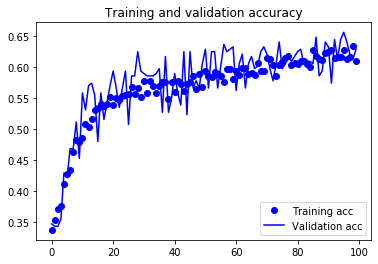

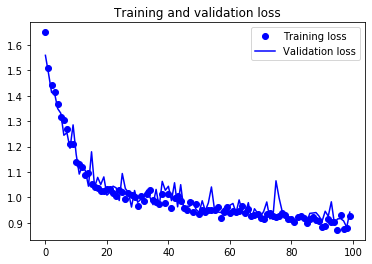

In [0]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Load OR Save the model

In [0]:
#Save the model!
model_DropOut_Augmented.save(os.path.join(base_dir,'Models/Model_Task_2.2_WithAugmentation_Definitivo_0.6726.h5'))

In [0]:
#Restore the saved model
model_DropOut = tf.keras.models.load_model(os.path.join(base_dir,'Models/Model_Task_2.1_WithDROPOUT.h5'))

# Show the model architecture
model_DropOut.summary()

# USING DCCNN


## Getting the Data 

In [0]:
from tensorflow.keras.utils import to_categorical
def load_training():
  train_images = np.load(os.path.join(base_dir,'Tensors/train_tensor.npy'))
  train_labels = np.load(os.path.join(base_dir,'Tensors/train_labels.npy'))
  test_images = np.load(os.path.join(base_dir,'Tensors/public_test_tensor.npy'))
  test_lables = np.load(os.path.join(base_dir,'Tensors/public_test_labels.npy'))
  return train_images,train_labels, test_images, test_lables
 
train_images, train_labels, test_images, test_lable = load_training()




### Reshape

In [0]:

train_images = train_images.reshape((5352, 150, 150,1))
train_images = train_images.astype('float32') / 65535




test_images = test_images.reshape((672, 150, 150,1))
test_images = test_images.astype('float32') / 65535


In [0]:
print(train_images[0:100])

### Removing the baseline

In [0]:
#Here i manage the input tensors, removing the baseline patch and the relative labels in order to perform classification
SubTrainArray =  np.empty_like(train_images)
SubTrainArray =  np.delete(train_images, np.s_[::2], 0)
print(SubTrainArray[1]) 
SubLabelArray = np.empty_like(train_labels)
SubLabelArray =  np.delete(train_labels, np.s_[::2], 0)



[[[0.59464407]
  [0.5761654 ]
  [0.57012284]
  ...
  [0.5654231 ]
  [0.5775082 ]
  [0.58255893]]

 [[0.5802091 ]
  [0.58490884]
  [0.5684444 ]
  ...
  [0.5919585 ]
  [0.593637  ]
  [0.5933013 ]]

 [[0.6037232 ]
  [0.6007019 ]
  [0.593637  ]
  ...
  [0.6057374 ]
  [0.6007019 ]
  [0.6054017 ]]

 ...

 [[0.50159454]
  [0.49553674]
  [0.5177081 ]
  ...
  [0.52242315]
  [0.53920805]
  [0.53316545]]

 [[0.51032275]
  [0.49991608]
  [0.5113298 ]
  ...
  [0.52007324]
  [0.5442588 ]
  [0.5146868 ]]

 [[0.49822232]
  [0.5029374 ]
  [0.5130083 ]
  ...
  [0.5143511 ]
  [0.5308156 ]
  [0.52544445]]]


### Editing the label 

In [0]:
#to_categorical requires that the label should be in the range [0,number_Class] 
leng = len(SubLabelArray)
SubLabelArray_4 = np.empty_like(SubLabelArray)
for i in range(leng):
    if SubLabelArray[i] == 1:
      SubLabelArray_4[i] = 0
    if SubLabelArray[i] == 2:
      SubLabelArray_4[i] = 1
    if SubLabelArray[i] == 3:
      SubLabelArray_4[i] = 2
    if SubLabelArray[i] == 4:
      SubLabelArray_4[i] = 3

print(SubLabelArray_4[0:1000])
print(SubLabelArray_4[2000:])



[1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0
 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0
 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1
 0 0 1 1 0 0 1 1 0 0 0 0 

### Modifiyng the test set

In [0]:
#Here i manage the TEST data set, removing baseline
SubTestArray =  np.empty_like(test_images)
SubTestArray =  np.delete(test_images, np.s_[::2], 0)

SubTestLabelArray = np.empty_like(test_lable)
SubTestLabelArray =  np.delete(test_lable, np.s_[::2], 0)
print(SubTestLabelArray[0:1000])
print(SubTestLabelArray[2000:3000])

[2 2 2 2 1 1 2 2 1 2 2 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 1 1 1 1 2 2 1 1 2 2 2 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 2 1
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2
 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 1 2 1
 1 1 1 2 2 1 1 1 1 1 2 2 2 1 1 2 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 3 4 4 3 3 3 3
 3 3 4 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 3 3 4 4 3 3 4 4 4 4 4 4
 4 3 3 3 3 4 4 4 3 3 3 3 3 3 4 3 3 3 3 3 3 4 4 4 4 3 3 3 3 4 3 3 4 4 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 3 3 3 3 3 3 3
 3 3 3]
[]


In [0]:
leng = len(SubTestLabelArray)
SubTestLabelArray_Edited = np.empty_like(SubTestLabelArray)
for i in range(leng):
    if SubTestLabelArray[i] == 1:
      SubTestLabelArray_Edited[i] = 0
    if SubTestLabelArray[i] == 2:
      SubTestLabelArray_Edited[i] = 1
    if SubTestLabelArray[i] == 3:
      SubTestLabelArray_Edited[i] = 2
    if SubTestLabelArray[i] == 4:
      SubTestLabelArray_Edited[i] = 3

print(SubTestLabelArray_Edited[0:1000])
print(SubTestLabelArray_Edited[1000:])

[1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0
 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 2 2 2 3 3 2 2 2 2
 2 2 3 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 2 2 3 3 2 2 3 3 3 3 3 3
 3 2 2 2 2 3 3 3 2 2 2 2 2 2 3 2 2 2 2 2 2 3 3 3 3 2 2 2 2 3 2 2 3 3 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 2 2 2 2 2 2 2
 2 2 2]
[]


### To categorical

In [0]:

from keras.utils import to_categorical
LabelArray_Categorical = to_categorical(SubLabelArray_4,4)
Test_label_categorical = to_categorical(SubTestLabelArray_Edited,4)

Using TensorFlow backend.


In [0]:
print(LabelArray_Categorical[0:1000])
print(LabelArray_Categorical[2000:])

### Shuffle

In [0]:
#eseguo uno shuffle dei dati 
 from sklearn.utils import shuffle

 TrainArray_Shuffled, LabelArray_Shuffled = shuffle( SubTrainArray, LabelArray_Categorical, random_state=42)



In [0]:
#Printing in order to check if the shuffled has been performed well
print(LabelArray_Shuffled[0:1000])
print(LabelArray_Shuffled[2000:3000])


## Model

In [0]:
%tensorflow_version 1.14
import tensorflow as tf
from tensorflow import keras
from keras.layers import merge, Input
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D, Convolution2D

img_rows, img_cols = 150, 150

nb_filters_1 = 32
nb_filters_2 = 64
nb_filters_3 = 128
nb_conv = 3

init = keras.layers.Input(shape=(150,150,1),)

fork11 = keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv),  activation='relu')(init)
fork12 = keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv), activation='relu')(init)
merge1 = keras.layers.Subtract()([fork11, fork12,])
maxpool1 = keras.layers.MaxPooling2D(strides=(2,2),)(merge1)

fork21 = keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001 ))(maxpool1)
fork22 = keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(maxpool1)
merge2 = keras.layers.Subtract()([fork21, fork22, ])
maxpool2 = keras.layers.MaxPooling2D(strides=(2,2), )(merge2)

fork31 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001) )(maxpool2)
fork32 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001) )(maxpool2)
fork33 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001 ))(maxpool2)
fork34 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(maxpool2)
fork35 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(maxpool2)
fork36 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001 ))(maxpool2)
merge3 = keras.layers.Concatenate()([fork31, fork32, fork33, fork34, fork35, fork36, ]) 
maxpool3 = keras.layers.MaxPooling2D(strides=(2,2), )(merge3)


flatten = keras.layers.Flatten()(maxpool3)
dropout = keras.layers.Dropout(0.4)(flatten)
dense1 = keras.layers.Dense(128, activation="relu")(dropout)
dense2 = keras.layers.Dense(64, activation="relu")(dense1)
output = keras.layers.Dense(4, activation="softmax")(dense2)

model = keras.models.Model(init, output)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
model.summary()

In [0]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

## 10-Cross validation

In [0]:
#cross-validation, SUL TRAINING ESTRATTO e shuffled
import numpy as np
keras.layers.Conv2D?
keras.layers.MaxPooling2D?
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from keras.layers import merge, Input
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D, Convolution2D
import warnings
warnings.filterwarnings('ignore')

def get_model():

  img_rows, img_cols = 150, 150

  nb_filters_1 = 32
  nb_filters_2 = 64
  nb_filters_3 = 128
  nb_conv = 3

  init = keras.layers.Input(shape=(150,150,1),)

  fork11 = keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv),  activation='relu')(init)
  fork12 = keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv), activation='relu')(init)
  merge1 = keras.layers.Subtract()([fork11, fork12,])
  maxpool1 = keras.layers.MaxPooling2D(strides=(2,2),)(merge1)

  fork21 = keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001 ))(maxpool1)
  fork22 = keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(maxpool1)
  merge2 = keras.layers.Subtract()([fork21, fork22, ])
  maxpool2 = keras.layers.MaxPooling2D(strides=(2,2), )(merge2)

  fork31 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001) )(maxpool2)
  fork32 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001) )(maxpool2)
  fork33 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001 ))(maxpool2)
  fork34 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(maxpool2)
  fork35 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(maxpool2)
  fork36 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001 ))(maxpool2)
  merge3 = keras.layers.Concatenate()([fork31, fork32, fork33, fork34, fork35, fork36, ]) 
  maxpool3 = keras.layers.MaxPooling2D(strides=(2,2), )(merge3)


  flatten = keras.layers.Flatten()(maxpool3)
  dropout = keras.layers.Dropout(0.4)(flatten)
  dense1 = keras.layers.Dense(128, activation="relu")(dropout)
  dense2 = keras.layers.Dense(64, activation="relu")(dense1)
  output = keras.layers.Dense(4, activation="softmax")(dense2)



  Cross_model = keras.models.Model(init, output)

  return Cross_model

def plot():
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  return


############################# CROSS VALIDATION ######################

k = 10
num_val_samples = len(TrainArray_Shuffled) // k
num_epochs = 40
History_Arr =[]
Cross_model = get_model()
Cross_model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

for i in range(k):
  print('processing fold #', i)
  val_data = TrainArray_Shuffled[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = LabelArray_Shuffled[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([TrainArray_Shuffled[:i * num_val_samples],TrainArray_Shuffled[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([LabelArray_Shuffled[:i * num_val_samples],LabelArray_Shuffled[(i + 1) * num_val_samples:]],axis=0)
  history = Cross_model.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=32)
  History_Arr.append(history)
  Cross_model = get_model()
  Cross_model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  plot()

## FITTING COMPLETO
Dopo la cross validation, fitto su tutto il DATASET

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(TrainArray_Shuffled, LabelArray_Shuffled, epochs=60,callbacks=[callback], batch_size=32)


Train on 2676 samples
Epoch 1/60
2676/2676 [==============================] - 14s 5ms/sample - loss: 1.4879 - categorical_accuracy: 0.3501
Epoch 2/60
2676/2676 [==============================] - 14s 5ms/sample - loss: 1.3604 - categorical_accuracy: 0.4226
Epoch 3/60
2676/2676 [==============================] - 14s 5ms/sample - loss: 1.2628 - categorical_accuracy: 0.4716
Epoch 4/60
2676/2676 [==============================] - 14s 5ms/sample - loss: 1.2060 - categorical_accuracy: 0.4936
Epoch 5/60
2676/2676 [==============================] - 14s 5ms/sample - loss: 1.1726 - categorical_accuracy: 0.4858
Epoch 6/60
2676/2676 [==============================] - 14s 5ms/sample - loss: 1.1554 - categorical_accuracy: 0.4907
Epoch 7/60
2676/2676 [==============================] - 14s 5ms/sample - loss: 1.1296 - categorical_accuracy: 0.5086
Epoch 8/60
2676/2676 [==============================] - 14s 5ms/sample - loss: 1.1286 - categorical_accuracy: 0.5037
Epoch 9/60
2676/2676 [====================

## Plotting

In [0]:
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evalutate the model

In [0]:
#evaluate the model


test_loss, test_acc = model.evaluate(SubTestArray, Test_label_categorical,batch_size=32, verbose= 1)
print(test_loss)
print(test_acc)

336/336 [==============================] - 1s 2ms/sample - loss: 2.3332 - categorical_accuracy: 0.4821
2.333171708243234
0.48214287


## Load OR Save the model

In [0]:
#Save the model!
model.save(os.path.join(base_dir,'Models/Model_Task_2.2_DCCN_BaseVersion_0.54.h5'))

# DCCNN: Adding Data Augmentation

In [0]:
def load_training():
  train_images = np.load(os.path.join(base_dir,'Tensors/train_tensor.npy'))
  train_labels = np.load(os.path.join(base_dir,'Tensors/train_labels.npy'))
  test_images = np.load(os.path.join(base_dir,'Tensors/public_test_tensor.npy'))
  test_lables = np.load(os.path.join(base_dir,'Tensors/public_test_labels.npy'))
  return train_images,train_labels, test_images, test_lables
 
train_images_Augmented, train_labels_Augmented, test_images_Augmented, test_lable_Augmented = load_training()

train_images_Augmented = train_images_Augmented.reshape((5352, 150, 150,1))
test_images_Augmented = test_images_Augmented.reshape((672, 150, 150,1))



## Removing the baseline

In [0]:
#Here i manage the input tensors, removing the baseline patch and the relative labels in order to perform classification
SubTrainArray =  np.empty_like(train_images_Augmented)
SubTrainArray =  np.delete(train_images_Augmented, np.s_[::2], 0)
print(SubTrainArray[1]) 
SubLabelArray = np.empty_like(train_labels_Augmented)
SubLabelArray =  np.delete(train_labels_Augmented, np.s_[::2], 0)



[[[38970]
  [37759]
  [37363]
  ...
  [37055]
  [37847]
  [38178]]

 [[38024]
  [38332]
  [37253]
  ...
  [38794]
  [38904]
  [38882]]

 [[39565]
  [39367]
  [38904]
  ...
  [39697]
  [39367]
  [39675]]

 ...

 [[32872]
  [32475]
  [33928]
  ...
  [34237]
  [35337]
  [34941]]

 [[33444]
  [32762]
  [33510]
  ...
  [34083]
  [35668]
  [33730]]

 [[32651]
  [32960]
  [33620]
  ...
  [33708]
  [34787]
  [34435]]]


## Editing the label 

In [0]:
#to_categorical requires that the label should be in the range [0,number_Class] 
leng = len(SubLabelArray)
SubLabelArray_4 = np.empty_like(SubLabelArray)
for i in range(leng):
    if SubLabelArray[i] == 1:
      SubLabelArray_4[i] = 0
    if SubLabelArray[i] == 2:
      SubLabelArray_4[i] = 1
    if SubLabelArray[i] == 3:
      SubLabelArray_4[i] = 2
    if SubLabelArray[i] == 4:
      SubLabelArray_4[i] = 3

print(SubLabelArray_4[0:1000])
print(SubLabelArray_4[2000:])



[1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0
 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0
 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1
 0 0 1 1 0 0 1 1 0 0 0 0 

## To categorical

In [0]:
#Se uso softmax
from keras.utils import to_categorical
SubLabelArray_Categorical = to_categorical(SubLabelArray_4,4)

In [0]:
print(SubLabelArray_Categorical[0:1000])
print(SubLabelArray_Categorical[2000:])

## Shuffle

In [0]:
#eseguo uno shuffle dei dati CON SOFTMAX
 from sklearn.utils import shuffle

 #SubTrainArray_Shuffled, SubLabelArray_Shuffled = shuffle( SubTrainArray, SubLabelArray_Categorical, random_state=100)
TrainArray_Shuffled_Augmented, LabelArray_Shuffled_Augmented = shuffle( SubTrainArray, SubLabelArray_Categorical, random_state=42)



In [0]:
#Printing in order to check if the shuffled has been performed well
print(TrainArray_Shuffled_Augmented[0:1000])
print(LabelArray_Shuffled_Augmented[2000:3000])


### Modifiyng the test set

In [0]:
#Here i manage the TEST data set, removing baseline
SubTestArray =  np.empty_like(test_images_Augmented)
SubTestArray =  np.delete(test_images_Augmented, np.s_[::2], 0)

SubTestLabelArray = np.empty_like(test_lable_Augmented)
SubTestLabelArray =  np.delete(test_lable_Augmented, np.s_[::2], 0)
print(SubTestLabelArray[0:1000])
print(SubTestLabelArray[2000:3000])

[2 2 2 2 1 1 2 2 1 2 2 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 1 1 1 1 2 2 1 1 2 2 2 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 2 1
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2
 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 1 2 1
 1 1 1 2 2 1 1 1 1 1 2 2 2 1 1 2 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 3 4 4 3 3 3 3
 3 3 4 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 3 3 4 4 3 3 4 4 4 4 4 4
 4 3 3 3 3 4 4 4 3 3 3 3 3 3 4 3 3 3 3 3 3 4 4 4 4 3 3 3 3 4 3 3 4 4 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 4 4 4 4 4 4 3 3 4 4 4 4 4 4 4 3 3 3 3 3 3 3
 3 3 3]
[]


In [0]:
leng = len(SubTestLabelArray)
SubTestLabelArray_Edited = np.empty_like(SubTestLabelArray)
for i in range(leng):
    if SubTestLabelArray[i] == 1:
      SubTestLabelArray_Edited[i] = 0
    if SubTestLabelArray[i] == 2:
      SubTestLabelArray_Edited[i] = 1
    if SubTestLabelArray[i] == 3:
      SubTestLabelArray_Edited[i] = 2
    if SubTestLabelArray[i] == 4:
      SubTestLabelArray_Edited[i] = 3

print(SubTestLabelArray_Edited[0:1000])
print(SubTestLabelArray_Edited[1000:])

[1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0
 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 2 2 2 3 3 2 2 2 2
 2 2 3 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 2 2 3 3 2 2 3 3 3 3 3 3
 3 2 2 2 2 3 3 3 2 2 2 2 2 2 3 2 2 2 2 2 2 3 3 3 3 2 2 2 2 3 2 2 3 3 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 2 2 2 2 2 2 2
 2 2 2]
[]


### To categorical

In [0]:
#Se uso softmax
from keras.utils import to_categorical
Test_label_categorical = to_categorical(SubTestLabelArray_Edited,4)

##Splitting

In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import shuffle
import numpy as np


#splitting
train_data, val_data, train_targets, val_targets = train_test_split(TrainArray_Shuffled_Augmented, LabelArray_Shuffled_Augmented, test_size=0.1, stratify=LabelArray_Shuffled_Augmented)





In [0]:
print(train_data.shape)
print(val_targets)

In [0]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./65535,
      rotation_range=360,
      zoom_range=0.1, 
      horizontal_flip=True,
      fill_mode='nearest',
      data_format = "channels_last")

validation_datagen = ImageDataGenerator(rescale=1./65535,
      data_format = "channels_last")
test_datagen = ImageDataGenerator(rescale=1./65535,
      data_format = "channels_last")


In [0]:
print(Train_target_cat)

In [0]:


train_generator = train_datagen.flow(
        # This is the target directory
        train_data,
        train_targets,
        batch_size=32
        )

validation_generator = validation_datagen.flow(
        val_data,
        val_targets,
        batch_size=32)
test_generator = test_datagen.flow(
    SubTestArray,
    Test_label_categorical,
    batch_size = 32)


In [0]:
import matplotlib.pyplot as plt

augmented_images = [train_generator[0][0][0] for i in range(5)]
for data_batch, labels_batch in train_generator:
    plt.imshow(np.squeeze(data_batch[3]), cmap='Greys')
    plt.show()
    plt.imshow(np.squeeze(data_batch[4]), cmap='Greys')
    plt.show()
    plt.imshow(np.squeeze(data_batch[5]), cmap='Greys')
    plt.show()
    plt.imshow(np.squeeze(data_batch[1]), cmap='Greys')
    plt.show()
    plt.imshow(np.squeeze(data_batch[2]), cmap='Greys')
    plt.show()
    break

## FITTING

In [0]:

history = model.fit_generator(
      train_generator,
      steps_per_epoch=2408//32,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=268//32)
test_loss, test_acc = model.evaluate_generator(test_generator,verbose= 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 8 steps
Epoch 1/10
75/75 [==============================] - 5s 65ms/step - loss: 0.6985 - categorical_accuracy: 0.6982 - val_loss: 0.9116 - val_categorical_accuracy: 0.6133
Epoch 2/10
75/75 [==============================] - 5s 66ms/step - loss: 0.6850 - categorical_accuracy: 0.6999 - val_loss: 0.9116 - val_categorical_accuracy: 0.6289
Epoch 3/10
75/75 [==============================] - 5s 66ms/step - loss: 0.6788 - categorical_accuracy: 0.7079 - val_loss: 0.8914 - val_categorical_accuracy: 0.6562
Epoch 4/10
75/75 [==============================] - 5s 67ms/step - loss: 0.6720 - categorical_accuracy: 0.7096 - val_loss: 0.8413 - val_categorical_accuracy: 0.6602
Epoch 5/10
75/75 [==============================] - 5s 67ms/step - loss: 0.6659 - categorical_accuracy: 0.7079 - val_loss: 0.9202 - val_categorical_accuracy: 0.6562
Epoch 6/10
75/75 [==============================] - 5s 65ms/step - loss: 0.6871 - ca

KeyboardInterrupt: ignored

### Evalutate the model

In [0]:
test_loss, test_acc = model.evaluate_generator(test_generator,verbose= 1)
print(test_loss)
print(test_acc)

  ...
    to  
  ['...']
11/11 [==============================] - 0s 30ms/step - loss: 1.0131 - categorical_accuracy: 0.5536
1.0130909952250393
0.5535714


In [0]:
#Restore the saved model
model = tf.keras.models.load_model(os.path.join(base_dir,'Models/Model_Task_2.2_DCCN_BaseVersion_0.55.h5'))



In [0]:
#Save the model!Aug
model.save(os.path.join(base_dir,'Models/Model_Task_2.2_DCCN_Augmentation_Version_0.6310.h5'))

## Plotting

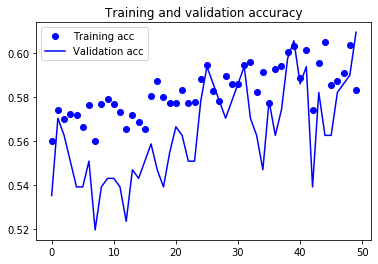

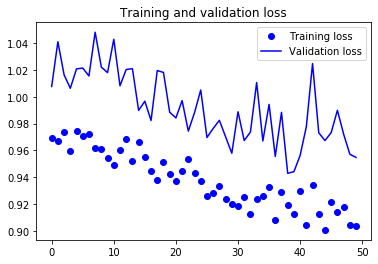

In [0]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Load OR Save the model

In [0]:
#Save the model!
model.save(os.path.join(base_dir,'Models/Model_Task_4_DCCNN_WithDataAugmentation_0.72.h5'))

# USING DCCNN with baseline for binary classification


## Model 

In [0]:
%tensorflow_version 1.14
!pip install keras==2.1.5
import tensorflow as tf
from tensorflow import keras
from keras.layers import merge, Input
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D, Convolution2D

img_rows, img_cols = 150, 150

nb_filters_1 = 32
nb_filters_2 = 64
nb_filters_3 = 128
nb_filters_4 = 256
nb_conv = 3

leaky = "relu"
init1 = keras.layers.Input(shape=(150,150,1),) #channel 1


init2 = keras.layers.Input(shape=(150,150,1),) #channel 2

fork11 = keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv), strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001))(init1)
fork12 = keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv),strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001))(init2)
merge1 = keras.layers.Subtract()([fork11, fork12,])
maxpool1 = keras.layers.MaxPooling2D(strides=(2,2),)(merge1)

fork21 = keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv),strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001) )(maxpool1)
fork22 = keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv),strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001))(maxpool1)
merge2 = keras.layers.Subtract()([fork21, fork22, ])
batchNorm2= keras.layers.BatchNormalization()(merge2)
maxpool2 = keras.layers.MaxPooling2D(strides=(2,2), )(batchNorm2)

fork31 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv),strides=(1,1),  activation=leaky,  kernel_regularizer=keras.regularizers.l2(0.001))(maxpool2)
fork32 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv),strides=(1,1),  activation=leaky,  kernel_regularizer=keras.regularizers.l2(0.001))(maxpool2)
merge3 = keras.layers.Subtract()([fork31, fork32, ]) 
batchNorm3= keras.layers.BatchNormalization()(merge3)
maxpool3 = keras.layers.MaxPooling2D(strides=(2,2), )(batchNorm3)

fork41 = keras.layers.Conv2D(nb_filters_4, (3, 3),strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001) )(maxpool3)
fork42 = keras.layers.Conv2D(nb_filters_4, (3, 3), strides=(1,1), activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001))(maxpool3)
merge4 = keras.layers.Subtract()([fork41, fork42, ]) 
batchNorm4= keras.layers.BatchNormalization()(merge4)
maxpool4 = keras.layers.MaxPooling2D(strides=(2,2), )(batchNorm4)

#dropout = keras.layers.Dropout(0.5)(maxpool3)

flatten = keras.layers.Flatten()(maxpool4)
dense1 = keras.layers.Dense(256, activation="relu")(flatten)
dropout1 = keras.layers.Dropout(0.5)(dense1)
dense3 = keras.layers.Dense(128, activation="relu")(dropout1)
output = keras.layers.Dense(2, activation="softmax")(dense3)


DCCNN_MODEL = keras.models.Model((init1, init2), output)


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
DCCNN_MODEL.summary()

In [0]:
DCCNN_MODEL.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

## Data Manipulation

In [0]:
from tensorflow.keras.utils import to_categorical
def load_training():
  train_images = np.load(os.path.join(base_dir,'Tensors/train_tensor.npy'))
  train_labels = np.load(os.path.join(base_dir,'Tensors/train_labels.npy'))
  test_images = np.load(os.path.join(base_dir,'Tensors/public_test_tensor.npy'))
  test_lables = np.load(os.path.join(base_dir,'Tensors/public_test_labels.npy'))
  return train_images,train_labels, test_images, test_lables
 
train_images_Augmented, train_labels_Augmented, test_images_Augmented, test_lable_Augmented = load_training()

train_images_Augmented = train_images_Augmented.reshape((5352, 150, 150,1))


test_images_Augmented = test_images_Augmented.reshape((672, 150, 150,1))



In [0]:
#TEST

from keras.utils import to_categorical
#splitting
Test_baseline_Not_Shuffled =  np.empty_like(test_images_Augmented)
Test_baseline_Not_Shuffled =  test_images_Augmented[::2]

Test_baseline_target_Not_Shuffled =  np.empty_like(test_lable_Augmented)
Test_baseline_target_Not_Shuffled =  test_lable_Augmented[::2]

#ABNORMALITY OPERATIONS
Test_abnormality_Not_Shuffled =  np.empty_like(test_images_Augmented)
Test_abnormality_Not_Shuffled =   test_images_Augmented[1:][::2]

Test_abnormality_target_Not_Shuffled =  np.empty_like(test_lable_Augmented)
Test_abnormality_target_Not_Shuffled =   test_lable_Augmented[1:][::2] #ora contiene solo le label delle abnormality


#editing labels
leng = len(Test_abnormality_target_Not_Shuffled)
Test_abnormality_target_4 = np.empty_like(Test_abnormality_target_Not_Shuffled)
for i in range(leng):
    if Test_abnormality_target_Not_Shuffled[i] == 1:
      Test_abnormality_target_4[i] = 0
    if Test_abnormality_target_Not_Shuffled[i] == 2:
      Test_abnormality_target_4[i] = 0
    if Test_abnormality_target_Not_Shuffled[i] == 3:
      Test_abnormality_target_4[i] = 1
    if Test_abnormality_target_Not_Shuffled[i] == 4:
      Test_abnormality_target_4[i] = 1


#TO_CATEGORICAL
Test_abnormality_target_Categorical = to_categorical(Test_abnormality_target_4,2)
Test_baseline_target_Categorical = to_categorical(Test_baseline_target_Not_Shuffled,2)


In [0]:
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


#splitting
baseline_Not_Shuffled =  np.empty_like(train_images_Augmented)
baseline_Not_Shuffled =  train_images_Augmented[::2]

baseline_target_Not_Shuffled =  np.empty_like(train_labels_Augmented)
baseline_target_Not_Shuffled =  train_labels_Augmented[::2]

#ABNORMALITY OPERATIONS
abnormality_Not_Shuffled =  np.empty_like(train_images_Augmented)
abnormality_Not_Shuffled =   train_images_Augmented[1:][::2]

abnormality_target_Not_Shuffled =  np.empty_like(train_labels_Augmented)
abnormality_target_Not_Shuffled =   train_labels_Augmented[1:][::2] #ora contiene solo le label delle abnormaluity

#shuffling

abnormality, abnormality_target = shuffle( abnormality_Not_Shuffled, abnormality_target_Not_Shuffled, random_state=42)
baseline, baseline_target = shuffle( baseline_Not_Shuffled, baseline_target_Not_Shuffled, random_state=42)

#editing labels
leng = len(abnormality_target)
abnormality_target_4 = np.empty_like(abnormality_target)
for i in range(leng):
    if abnormality_target[i] == 1:
      abnormality_target_4[i] = 0
    if abnormality_target[i] == 2:
      abnormality_target_4[i] = 0
    if abnormality_target[i] == 3:
      abnormality_target_4[i] = 1
    if abnormality_target[i] == 4:
      abnormality_target_4[i] = 1

#categorical

abnormality_target_Categorical = to_categorical(abnormality_target_4,2)
baseline_target_Categorical = to_categorical(baseline_target,2)



print(abnormality_target_Categorical[:10])

In [0]:

print(abnormality_target)

## 10-Cross validation

processing fold # 0
Train on 2409 samples, validate on 267 samples
Epoch 1/40
2409/2409 [==============================] - 4s 2ms/sample - loss: 6.2283 - categorical_accuracy: 0.6227 - val_loss: 63.5354 - val_categorical_accuracy: 0.5506
Epoch 2/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 1.7852 - categorical_accuracy: 0.6667 - val_loss: 1.6624 - val_categorical_accuracy: 0.6517
Epoch 3/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 1.3895 - categorical_accuracy: 0.7156 - val_loss: 1.1085 - val_categorical_accuracy: 0.7079
Epoch 4/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 1.3009 - categorical_accuracy: 0.7642 - val_loss: 3.0320 - val_categorical_accuracy: 0.6292
Epoch 5/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 0.9198 - categorical_accuracy: 0.7916 - val_loss: 2.0804 - val_categorical_accuracy: 0.5655
Epoch 6/40
2409/2409 [==============================] - 3s 1ms/sample - loss: 0.76

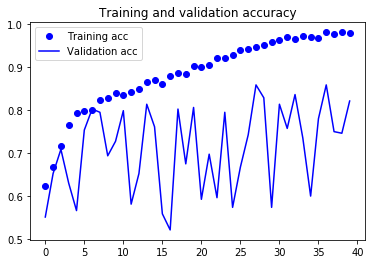

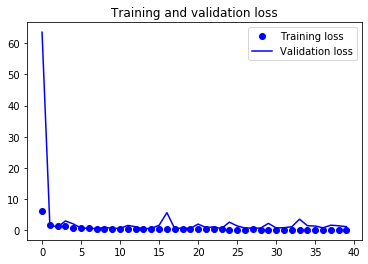

processing fold # 1
Train on 2409 samples, validate on 267 samples
Epoch 1/40
2409/2409 [==============================] - 4s 2ms/sample - loss: 4.7344 - categorical_accuracy: 0.6065 - val_loss: 17.1069 - val_categorical_accuracy: 0.4719
Epoch 2/40
1760/2409 [====================>.........] - ETA: 0s - loss: 1.7967 - categorical_accuracy: 0.6817

KeyboardInterrupt: ignored

In [0]:
#cross-validation, SUL TRAINING ESTRATTO e shuffled
import numpy as np
keras.layers.Conv2D?
keras.layers.MaxPooling2D?
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def get_model():

  nb_filters_1 = 32
  nb_filters_2 = 64
  nb_filters_3 = 128
  nb_filters_4 = 256
  nb_conv = 3

  leaky = "relu"
  init1 = keras.layers.Input(shape=(150,150,1),) #channel 1


  init2 = keras.layers.Input(shape=(150,150,1),) #channel 2

  fork11 = keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv), strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001))(init1)
  fork12 = keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv),strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001))(init2)
  merge1 = keras.layers.Subtract()([fork11, fork12,])
  maxpool1 = keras.layers.MaxPooling2D(strides=(2,2),)(merge1)

  fork21 = keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv),strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001) )(maxpool1)
  fork22 = keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv),strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001))(maxpool1)
  merge2 = keras.layers.Subtract()([fork21, fork22, ])
  batchNorm2= keras.layers.BatchNormalization()(merge2)
  maxpool2 = keras.layers.MaxPooling2D(strides=(2,2), )(batchNorm2)

  fork31 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv),strides=(1,1),  activation=leaky,  kernel_regularizer=keras.regularizers.l2(0.001))(maxpool2)
  fork32 = keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv),strides=(1,1),  activation=leaky,  kernel_regularizer=keras.regularizers.l2(0.001))(maxpool2)
  merge3 = keras.layers.Subtract()([fork31, fork32, ]) 
  batchNorm3= keras.layers.BatchNormalization()(merge3)
  maxpool3 = keras.layers.MaxPooling2D(strides=(2,2), )(batchNorm3)

  fork41 = keras.layers.Conv2D(nb_filters_4, (3, 3),strides=(1,1),  activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001) )(maxpool3)
  fork42 = keras.layers.Conv2D(nb_filters_4, (3, 3), strides=(1,1), activation=leaky, kernel_regularizer=keras.regularizers.l2(0.001))(maxpool3)
  merge4 = keras.layers.Subtract()([fork41, fork42, ]) 
  batchNorm4= keras.layers.BatchNormalization()(merge4)
  maxpool4 = keras.layers.MaxPooling2D(strides=(2,2), )(batchNorm4)

  #dropout = keras.layers.Dropout(0.5)(maxpool3)

  flatten = keras.layers.Flatten()(maxpool4)
  dense1 = keras.layers.Dense(256, activation="relu")(flatten)
  dropout1 = keras.layers.Dropout(0.5)(dense1)
  dense3 = keras.layers.Dense(128, activation="relu")(dropout1)
  output = keras.layers.Dense(2, activation="softmax")(dense1)

  Cross_model = keras.models.Model((init1, init2), output)
  return Cross_model

def plot():
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  return


############################# CROSS VALIDATION ######################

k = 10

num_epochs = 40
History_Arr =[]
Cross_model = get_model()
Cross_model.compile(optimizer='RMSprop',loss='categorical_crossentropy', metrics=['categorical_accuracy'])


num_val_samples = len(baseline) // k
for i in range(k):
  print('processing fold #', i)
  val_data_ABNORMALITY =  abnormality[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets_ABNORMALITY = abnormality_target_Categorical[i * num_val_samples: (i + 1) * num_val_samples]
  val_data_BASELINE = baseline[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data_ABN =    np.concatenate([abnormality[:i * num_val_samples],abnormality[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets_ABN = np.concatenate([abnormality_target_Categorical[:i * num_val_samples],abnormality_target_Categorical[(i + 1) * num_val_samples:]],axis=0)
  partial_train_data_BASE = np.concatenate([baseline[:i * num_val_samples],baseline[(i + 1) * num_val_samples:]],axis=0)
  history = Cross_model.fit([partial_train_data_BASE,partial_train_data_ABN ], partial_train_targets_ABN, validation_data=((val_data_BASELINE,val_data_ABNORMALITY), val_targets_ABNORMALITY), epochs=num_epochs, batch_size=32)
  History_Arr.append(history)
  Cross_model = get_model()
  Cross_model.compile(optimizer='RMSprop',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  plot()

## FITTING COMPLETO
Dopo la cross validation, fitto su tutto il DATASET

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

num_epochs = 40
history = DCCNN_MODEL.fit([baseline,abnormality ], abnormality_target_Categorical ,   epochs=num_epochs, batch_size=32)

Train on 2676 samples
Epoch 1/40
2676/2676 [==============================] - 4s 1ms/sample - loss: 0.5332 - categorical_accuracy: 0.8602
Epoch 2/40
2676/2676 [==============================] - 3s 983us/sample - loss: 0.5199 - categorical_accuracy: 0.8688
Epoch 3/40
2676/2676 [==============================] - 3s 980us/sample - loss: 0.5346 - categorical_accuracy: 0.8655
Epoch 4/40
2676/2676 [==============================] - 3s 980us/sample - loss: 0.4975 - categorical_accuracy: 0.8673
Epoch 5/40
2676/2676 [==============================] - 3s 979us/sample - loss: 0.4820 - categorical_accuracy: 0.8729
Epoch 6/40
2676/2676 [==============================] - 3s 993us/sample - loss: 0.4681 - categorical_accuracy: 0.8797
Epoch 7/40
2676/2676 [==============================] - 3s 990us/sample - loss: 0.4078 - categorical_accuracy: 0.8875
Epoch 8/40
2676/2676 [==============================] - 3s 980us/sample - loss: 0.4103 - categorical_accuracy: 0.8913
Epoch 9/40
2676/2676 [==============

## Evalutate the model

In [0]:
#evaluate the model

test_loss, test_acc = DCCNN_MODEL.evaluate((Test_baseline_Not_Shuffled,Test_abnormality_Not_Shuffled), Test_abnormality_target_Categorical,batch_size=32, verbose= 1)
print(test_loss)
print(test_acc)

336/336 [==============================] - 0s 1ms/sample - loss: 0.7338 - categorical_accuracy: 0.8631
0.7337613645054045
0.8630952


## Load OR Save the model

In [0]:
#Save the model!
DCCNN_MODEL.save(os.path.join(base_dir,'Models/Model_Task_2.2_DCCN_Baseline_BaseVersion_0.86.h5'))

## Adding Data Augmentation 

### Data Augmentation

In [0]:
def load_training():
  train_images = np.load(os.path.join(base_dir,'Tensors/train_tensor.npy'))
  train_labels = np.load(os.path.join(base_dir,'Tensors/train_labels.npy'))
  test_images = np.load(os.path.join(base_dir,'Tensors/public_test_tensor.npy'))
  test_lables = np.load(os.path.join(base_dir,'Tensors/public_test_labels.npy'))
  return train_images,train_labels, test_images, test_lables
 
train_images_Augmented, train_labels_Augmented, test_images_Augmented, test_lable_Augmented = load_training()

train_images_Augmented = train_images_Augmented.reshape((5352, 150, 150,1))
test_images_Augmented = test_images_Augmented.reshape((672, 150, 150,1))
test_images_Augmented = test_images_Augmented.astype('float32') / 65535


Test manipulation

In [0]:
#TEST

from keras.utils import to_categorical
#splitting
Test_baseline_Not_Shuffled =  np.empty_like(test_images_Augmented)
Test_baseline_Not_Shuffled =  test_images_Augmented[::2]

Test_baseline_target_Not_Shuffled =  np.empty_like(test_lable_Augmented)
Test_baseline_target_Not_Shuffled =  test_lable_Augmented[::2]

#ABNORMALITY OPERATIONS
Test_abnormality_Not_Shuffled =  np.empty_like(test_images_Augmented)
Test_abnormality_Not_Shuffled =   test_images_Augmented[1:][::2]

Test_abnormality_target_Not_Shuffled =  np.empty_like(test_lable_Augmented)
Test_abnormality_target_Not_Shuffled =   test_lable_Augmented[1:][::2] #ora contiene solo le label delle abnormality


#editing labels
leng = len(Test_abnormality_target_Not_Shuffled)
Test_abnormality_target_4 = np.empty_like(Test_abnormality_target_Not_Shuffled)
for i in range(leng):
    if Test_abnormality_target_Not_Shuffled[i] == 1:
      Test_abnormality_target_4[i] = 0
    if Test_abnormality_target_Not_Shuffled[i] == 2:
      Test_abnormality_target_4[i] = 0
    if Test_abnormality_target_Not_Shuffled[i] == 3:
      Test_abnormality_target_4[i] = 1
    if Test_abnormality_target_Not_Shuffled[i] == 4:
      Test_abnormality_target_4[i] = 1


#TO_CATEGORICAL
Test_abnormality_target_Categorical = to_categorical(Test_abnormality_target_4,2)
Test_baseline_target_Categorical = to_categorical(Test_baseline_target_Not_Shuffled,2)


In [0]:
print(Test_abnormality_Not_Shuffled)

In [0]:
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


#splitting
baseline_Not_Shuffled =  np.empty_like(train_images_Augmented)
baseline_Not_Shuffled =  train_images_Augmented[::2]

baseline_target_Not_Shuffled =  np.empty_like(train_labels_Augmented)
baseline_target_Not_Shuffled =  train_labels_Augmented[::2]

#ABNORMALITY OPERATIONS
abnormality_Not_Shuffled =  np.empty_like(train_images_Augmented)
abnormality_Not_Shuffled =   train_images_Augmented[1:][::2]

abnormality_target_Not_Shuffled =  np.empty_like(train_labels_Augmented)
abnormality_target_Not_Shuffled =   train_labels_Augmented[1:][::2] #ora contiene solo le label delle abnormaluity

#shuffling

abnormality, abnormality_target = shuffle( abnormality_Not_Shuffled, abnormality_target_Not_Shuffled, random_state=42)
baseline, baseline_target = shuffle( baseline_Not_Shuffled, baseline_target_Not_Shuffled, random_state=42)

#editing labels
leng = len(abnormality_target)
abnormality_target_4 = np.empty_like(abnormality_target)
for i in range(leng):
    if abnormality_target[i] == 1:
      abnormality_target_4[i] = 0
    if abnormality_target[i] == 2:
      abnormality_target_4[i] = 0
    if abnormality_target[i] == 3:
      abnormality_target_4[i] = 1
    if abnormality_target[i] == 4:
      abnormality_target_4[i] = 1

#categorical

abnormality_target_Categorical = to_categorical(abnormality_target_4,2)
baseline_target_Categorical = to_categorical(baseline_target,2)



print(abnormality_target_Categorical[:10])

In [0]:
#ABNORMALITY OPERATIONS

print(abnormality_target)

[2 3 1 ... 1 4 2]


In [0]:
print(base_train_data)
print(base_train_data.shape)

In [0]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def double_generator(train_base_images, train_abn_images, train_labels, subset, batch_size=32):

    gen = ImageDataGenerator(
      validation_split=0.1,
      rescale=1./65535,
      rotation_range=360,
      zoom_range=0.4, 
      horizontal_flip=True,
      vertical_flip = True,
      fill_mode='nearest'
    )

    gen.fit(train_abn_images)

    gen_abn = gen.flow(train_abn_images, train_labels,  batch_size=batch_size, subset=subset, seed=1)
    gen_base = gen.flow(train_base_images, train_labels, batch_size=batch_size, subset=subset, seed=1)

    while True:
        abn_img, abn_label = gen_abn.next()
        base_img, _ = gen_base.next()
        yield [base_img, abn_img], abn_label

train_generator = double_generator(baseline, abnormality, abnormality_target_Categorical, 'training', batch_size=32)
validation_generator = double_generator(baseline, abnormality, abnormality_target_Categorical, 'validation', batch_size=32)

### FITTING

In [0]:
history = DCCNN_MODEL.fit_generator(
      train_generator,
      steps_per_epoch=2408//32,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=268//32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 8 steps
Epoch 1/50
75/75 [==============================] - 9s 122ms/step - loss: 2.4346 - categorical_accuracy: 0.5957 - val_loss: 1.2110 - val_categorical_accuracy: 0.5234
Epoch 2/50
75/75 [==============================] - 9s 123ms/step - loss: 1.6862 - categorical_accuracy: 0.6125 - val_loss: 1.7791 - val_categorical_accuracy: 0.5447
Epoch 3/50
75/75 [==============================] - 9s 122ms/step - loss: 1.7197 - categorical_accuracy: 0.6083 - val_loss: 1.6057 - val_categorical_accuracy: 0.6255
Epoch 4/50
75/75 [==============================] - 9s 124ms/step - loss: 1.5457 - categorical_accuracy: 0.6264 - val_loss: 1.2696 - val_categorical_accuracy: 0.5617
Epoch 5/50
75/75 [==============================] - 9s 124ms/step - loss: 1.2007 - categorical_accuracy: 0.6382 - val_loss: 1.9494 - val_categorical_accuracy: 0.6723
Epoch 6/50
75/75 [==============================] - 9s 125ms/step - loss: 1.328

### Evalutate the model

In [0]:


test_loss, test_acc = DCCNN_MODEL.evaluate((Test_baseline_Not_Shuffled, Test_abnormality_Not_Shuffled),Test_abnormality_target_Categorical,batch_size=32,  verbose= 1)
print(test_loss)
print(test_acc)

336/336 [==============================] - 0s 860us/sample - loss: 1.2980 - categorical_accuracy: 0.5923
1.298019786675771
0.5922619


### Load OR Save the model

In [0]:
#Save the model!
model_DUAL_CHANNEL.save(os.path.join(base_dir,'Models/Model_Task_4_DCCNN_Corretto_WithDataAugmentation_0.5982.h5'))